# EMG WORD PREDICTION

### IMPORT NECESSARY MODULES

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
import glob
import pickle
import tqdm
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
import matplotlib as mlp
import matplotlib.pyplot as plt
mlp.rc("xtick",labelsize=12)
mlp.rc("ytick",labelsize=12)
mlp.rc("axes",labelsize=14)

plt.rcParams['figure.figsize'] = [10,5]
plt.rcParams['figure.dpi'] = 300

from scipy import signal
from scipy.stats import zscore
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

import librosa

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA

from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import StratifiedKFold
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV


from sklearn.pipeline import Pipeline

import tensorflow as tf
from tensorflow import keras

CURR_DIR = os.getcwd()

In [2]:

MAIN_DIR = os.path.join(CURR_DIR,"..","..")
DATA_DIR = os.path.join(MAIN_DIR,"dataset")
FILE_DIR = os.path.join(MAIN_DIR,"dataset","pickle")
FIG_DIR = os.path.join(MAIN_DIR,"figures")
os.makedirs(FIG_DIR,exist_ok=True)

SPEAKER = ["RL","RN","SR","US"]
MODE = ["mentally","mouthed"]
WORDS = LABELS = ["add","call","go","later","left","reply","right","stop","subtract","you"]

SAMPLING_FREQ = 250 
NUM_CHANNELS = 8


# a function to save plotted figures
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(FIG_DIR, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


In [3]:
DATASET = os.listdir(FILE_DIR)
DATASET.sort()
print(DATASET[0:6])

['ALL_feature_spectral_me.pickle', 'ALL_feature_spectral_mo.pickle', 'ALL_feature_time_me.pickle', 'ALL_feature_time_mo.pickle', 'ALL_feature_time_spectral_me.pickle', 'ALL_feature_time_spectral_mo.pickle']


In [4]:

# feature_spectral_mental = pickle.load(open(os.path.join(FILE_DIR,DATASET[0]),"rb"))
feature_spectral_mouthed = pickle.load(open(os.path.join(FILE_DIR,DATASET[1]),"rb"))
# feature_time_mental = pickle.load(open(os.path.join(FILE_DIR,DATASET[2]),"rb"))
feature_time_mouthed = pickle.load(open(os.path.join(FILE_DIR,DATASET[3]),"rb"))
# feature_time_spectral_mental = pickle.load(open(os.path.join(FILE_DIR,DATASET[4]),"rb"))
# feature_time_spectral_mental = pickle.load(open(os.path.join(FILE_DIR,DATASET[5]),"rb"))

In [5]:
# feature_time_mental.keys()
feature_time_mouthed.keys()

dict_keys(['data', 'label'])

In [6]:
X_spectral = feature_spectral_mouthed["data"]
Y_spectral = feature_spectral_mouthed["label"]

X_time = feature_time_mouthed["data"]
Y_time = feature_time_mouthed["label"]

In [7]:
print(X_spectral.shape)
print(Y_spectral.shape)

print(X_time.shape)
print(Y_time.shape)

(2230, 885, 72)
(2230,)
(2230, 885, 40)
(2230,)


### LABEL ENCODING (MLP AND CNN)

In [12]:
encoder = LabelEncoder()
Y = encoder.fit_transform(Y_spectral)
Y_1hot = tf.keras.utils.to_categorical(Y_spectral, num_classes = 10)
print(encoder.classes_)
print("Encoded labels (normal): \n",Y[0:5])
print("Encoded labels (ONE-HOT): \n",Y_1hot[0:5])

# encoder = LabelEncoder()
# Y_time = encoder.fit_transform(Y_time)
# Y_1hot_time = tf.keras.utils.to_categorical(Y_time, num_classes = 10)
# print(encoder.classes_)
# print("Encoded labels (normal): \n",Y_time[0:5])
# print("Encoded labels (ONE-HOT): \n",Y_1hot_time[0:5])

# encoder = LabelEncoder()
# Y_spectral = encoder.fit_transform(Y_spectral)
# Y_1hot_spectral = tf.keras.utils.to_categorical(Y_spectral, num_classes = 10)
# print(encoder.classes_)
# print("Encoded labels (normal): \n",Y_spectral[0:5])
# print("Encoded labels (ONE-HOT): \n",Y_1hot_spectral[0:5])

[0 1 2 3 4 5 6 7 8 9]
Encoded labels (normal): 
 [1 1 1 1 1]
Encoded labels (ONE-HOT): 
 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [13]:
def train_test_split(X,Y):
    split = StratifiedShuffleSplit(n_splits=1, test_size =0.1, random_state=42)
    train_id, test_id = next(split.split(X,Y))
    return np.array([X[n] for n in train_id]), np.array([Y[n] for n in train_id]), np.array([X[n] for n in test_id]),np.array([Y[n] for n in test_id])

In [60]:
def plotCM(y, predictions,y2,predictions2,filename=" "):
    cm = confusion_matrix(y, predictions)
#     print(cm)
#     plt.suptitle("KNN\n\n")
    plt.subplot(121)
    plt.title("With Temporal Features")
    plt.imshow(confusion_matrix(y, predictions,normalize="true"), interpolation = 'nearest',cmap = plt.cm.Reds)
    plt.xticks(range(len(LABELS)), LABELS, rotation = 45)
    plt.yticks(range(len(LABELS)), LABELS)
    
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')

    for i in range(10):
        for j in range(10):
            plt.text(j,i, cm[i][j],horizontalalignment='center',verticalalignment='center')
   

    plt.subplot(122)
    plt.title("With Spectral Features")
    plt.imshow(confusion_matrix(y2, predictions2,normalize="true"), interpolation = 'nearest',cmap = plt.cm.Reds)
    plt.xticks(range(len(LABELS)), LABELS, rotation = 45)
    plt.yticks(range(len(LABELS)), LABELS)
    
#     plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    cm = confusion_matrix(y2, predictions2)
    
    for i in range(10):
        for j in range(10):
            plt.text(j,i, cm[i][j],horizontalalignment='center',verticalalignment='center')
    
    if(filename!=" "):
        save_fig(filename)
    plt.subplots_adjust(wspace=0.3)
    plt.show()

## MLP MODEL DEVELOPMENT

### FLATTEN DATA FOR MLP

In [56]:

X_MLP_time = np.array([x.flatten() for x in X_time])
print("Raw feature shape: ",X_MLP_time.shape)


X_MLP_spectral = np.array([x.flatten() for x in X_spectral])
print("Raw feature shape: ",X_MLP_spectral.shape)

Raw feature shape:  (2230, 35400)
Raw feature shape:  (2230, 63720)


### SCALE DATA

In [55]:
scalar = StandardScaler()
X_MLP_time = scalar.fit_transform(X_MLP_time,Y)
X_MLP_spectral = scalar.fit_transform(X_MLP_spectral,Y)

In [15]:
reducer = FastICA(n_components=100,random_state=42)
X_MLP_time = reducer.fit_transform(X_MLP_time)
X_MLP_spectral = reducer.fit_transform(X_MLP_spectral)

In [39]:
X_train_time,Y_train_time,X_test_time,Y_test_time = train_test_split(X_MLP_time,Y)

print("Train Set Shape of X: ",X_train_time.shape)
print("Test Set Shape of X: ",X_test_time.shape)

print("Train Set Shape of Y: ",Y_train_time.shape)
print("Test Set Shape of Y: ",Y_test_time.shape)


X_train_spectral,Y_train_spectral,X_test_spectral,Y_test_spectral = train_test_split(X_MLP_spectral,Y)

print("Train Set Shape of X: ",X_train_spectral.shape)
print("Test Set Shape of X: ",X_test_spectral.shape)

print("Train Set Shape of Y: ",Y_train_spectral.shape)
print("Test Set Shape of Y: ",Y_test_spectral.shape)

Train Set Shape of X:  (2007, 100)
Test Set Shape of X:  (223, 100)
Train Set Shape of Y:  (2007,)
Test Set Shape of Y:  (223,)
Train Set Shape of X:  (2007, 100)
Test Set Shape of X:  (223, 100)
Train Set Shape of Y:  (2007,)
Test Set Shape of Y:  (223,)


### DEFINE MODEL

In [41]:
def MLP_Classifier(X_train,Y_train,X_test,Y_test,PLOTS=True):
    MLP_model = keras.Sequential()
    MLP_model.add(keras.layers.Dense(units=200,activation="relu",input_shape=X_train[0].shape))
    MLP_model.add(keras.layers.Dropout(0.5))
    MLP_model.add(keras.layers.Dense(64,activation="relu"))
    MLP_model.add(keras.layers.Dense(64,activation="relu"))
    MLP_model.add(keras.layers.Dropout(0.5))
    MLP_model.add(keras.layers.Dense(10,activation="softmax"))
    print(MLP_model.summary())
    optimizer=keras.optimizers.Adam()
    MLP_model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy",metrics=["accuracy"])
    history = MLP_model.fit(X_train,Y_train,epochs=30,validation_data=(X_test,Y_test),verbose=1)    
    MLP_prediction = np.array(list(map(np.argmax,MLP_model.predict(X_test))))
    
#     if(PLOTS==True):
#         plt.plot(history.history["accuracy"],"r:")
#         plt.plot(history.history["loss"],"b--")
#         plt.xlabel("Epoch")
#         plt.ylabel("Accuracy/ Loss")
#         plt.legend(["Accuracy","Loss"])
    # save_fig("ACC_LOSS_US_FIltered")

    return Y_test,MLP_prediction,history

In [42]:
a,b,MLP_history_time = MLP_Classifier(X_train_time,Y_train_time,X_test_time,Y_test_time)
c,d,MLP_history_spectral = MLP_Classifier(X_train_spectral,Y_train_spectral,X_test_spectral,Y_test_spectral)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 200)               20200     
_________________________________________________________________
dropout_12 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 64)                12864     
_________________________________________________________________
dense_30 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_13 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 10)                650       
Total params: 37,874
Trainable params: 37,874
Non-trainable params: 0
__________________________________________________

Epoch 13/30
63/63 [==============================] - 0s 1ms/step - loss: 1.2484 - accuracy: 0.5855 - val_loss: 1.6750 - val_accuracy: 0.5695
Epoch 14/30
63/63 [==============================] - 0s 1ms/step - loss: 1.2183 - accuracy: 0.5959 - val_loss: 1.7017 - val_accuracy: 0.5740
Epoch 15/30
63/63 [==============================] - 0s 1ms/step - loss: 1.1608 - accuracy: 0.6099 - val_loss: 1.7216 - val_accuracy: 0.5874
Epoch 16/30
63/63 [==============================] - 0s 1ms/step - loss: 1.1324 - accuracy: 0.6183 - val_loss: 1.7447 - val_accuracy: 0.6233
Epoch 17/30
63/63 [==============================] - 0s 1ms/step - loss: 1.0877 - accuracy: 0.6378 - val_loss: 1.7438 - val_accuracy: 0.6278
Epoch 18/30
63/63 [==============================] - 0s 1ms/step - loss: 1.0682 - accuracy: 0.6537 - val_loss: 1.7663 - val_accuracy: 0.6547
Epoch 19/30
63/63 [==============================] - 0s 1ms/step - loss: 1.0243 - accuracy: 0.6617 - val_loss: 1.8019 - val_accuracy: 0.6502
Epoch 20/30
6

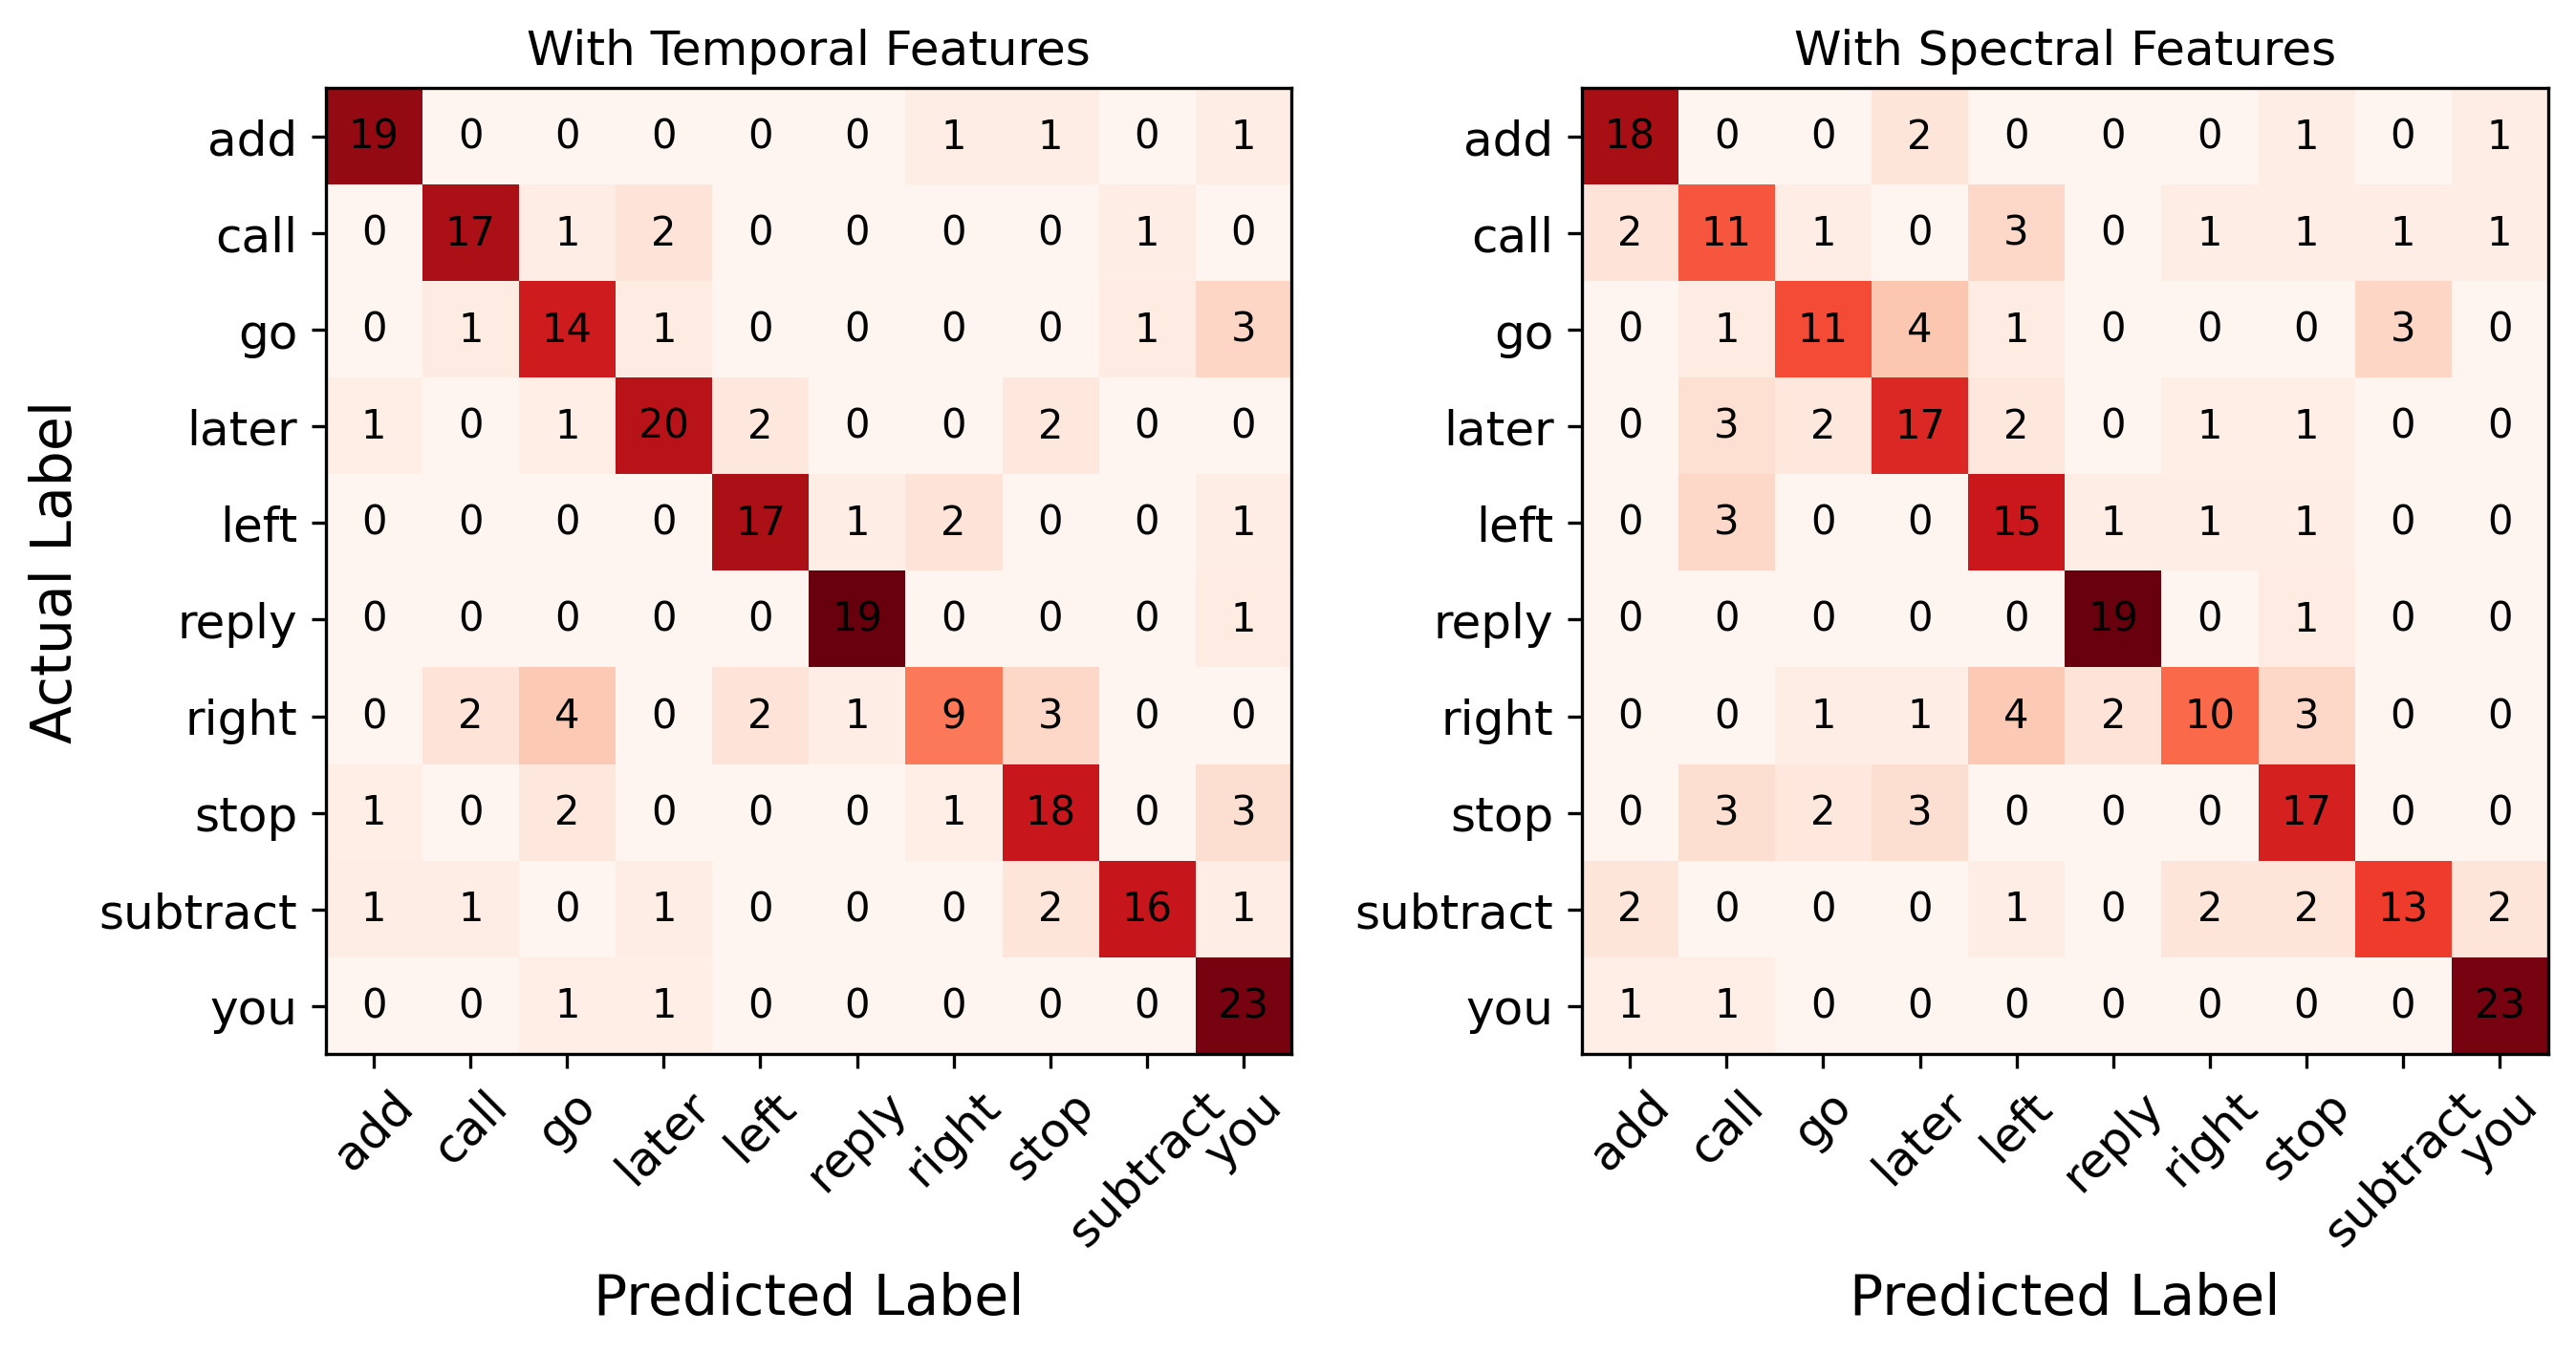

In [24]:
plotCM(a,b.flatten(),c,d.flatten())


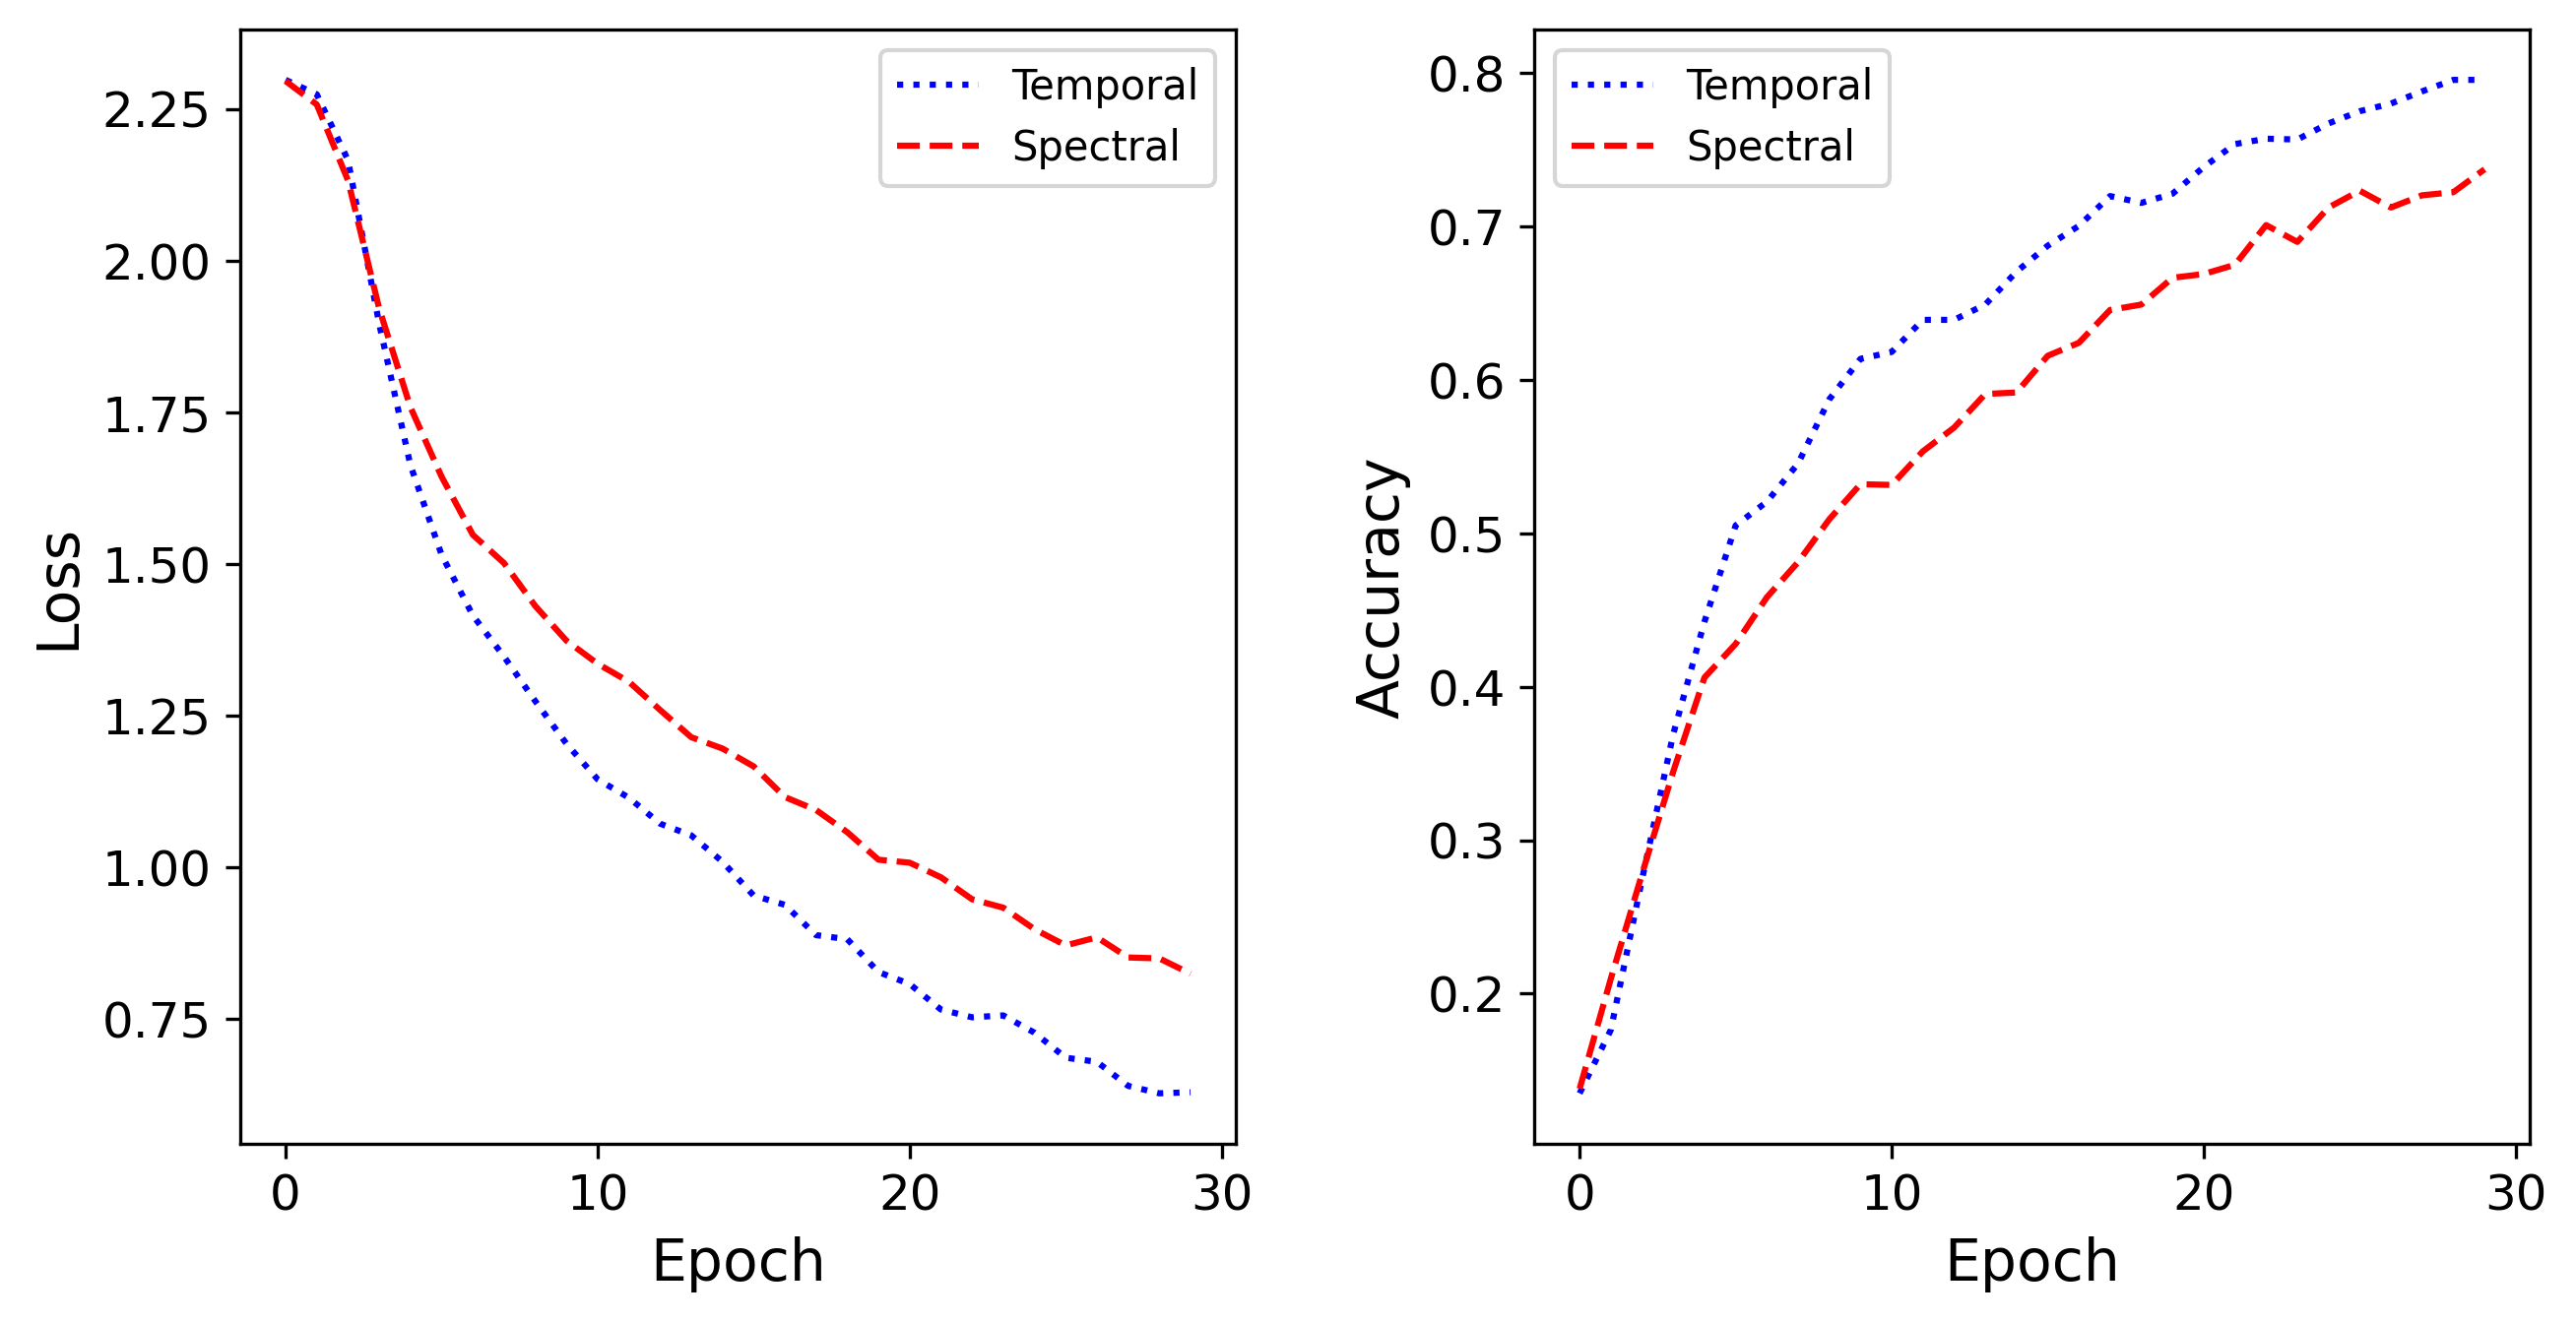

In [25]:

plt.subplot(121)
# plt.title("With Temporal Features")
plt.plot(MLP_history_time.history["loss"],"b:")
plt.plot(MLP_history_spectral.history["loss"],"r--")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(["Temporal","Spectral"])

plt.subplot(122)
# plt.title("With Temporal Features")
plt.plot(MLP_history_time.history["accuracy"],"b:")
plt.plot(MLP_history_spectral.history["accuracy"],"r--")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.subplots_adjust(wspace=0.3)
plt.legend(["Temporal","Spectral"])
# save_fig("ALL_MLP_ACCURACY_LOSS")
plt.show()

In [44]:
print("Precision/Recall with Temporal Features")
print(classification_report(a,b))

print("Precision/Recall with Spectral Features")
print(classification_report(c,d))

Precision/Recall with Temporal Features
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        22
           1       0.94      0.71      0.81        21
           2       0.70      0.70      0.70        20
           3       0.75      0.69      0.72        26
           4       0.70      0.90      0.79        21
           5       0.86      0.95      0.90        20
           6       0.76      0.62      0.68        21
           7       0.78      0.84      0.81        25
           8       0.82      0.64      0.72        22
           9       0.74      0.92      0.82        25

    accuracy                           0.78       223
   macro avg       0.79      0.78      0.78       223
weighted avg       0.79      0.78      0.78       223

Precision/Recall with Spectral Features
              precision    recall  f1-score   support

           0       0.83      0.86      0.84        22
           1       0.60      0.57      0.59        2

## CNN MODEL DEVELOPMENT

In [63]:
from copy import deepcopy

X_CNN_spectral = deepcopy(X_spectral)

X_CNN_time = deepcopy(X_time)

print(X_CNN_time.shape)

print(X_CNN_spectral.shape)

(2230, 885, 40)
(2230, 885, 72)


In [ ]:
X_train_time,Y_train_time,X_test_time,Y_test_time = train_test_split(X_CNN_time,Y)
print("Train Set Shape: ",X_train_time.shape)
print("Test Set Shape: ",X_test_time.shape)

print("Train Set Shape: ",Y_train_time.shape)
print("Test Set Shape: ",Y_test_time.shape)


X_train_spectral,Y_train_spectral,X_test_spectral,Y_test_spectral = train_test_split(X_CNN_spectral,Y)
print("Train Set Shape: ",X_train_spectral.shape)
print("Test Set Shape: ",X_test_spectral.shape)

print("Train Set Shape: ",Y_train_spectral.shape)
print("Test Set Shape: ",Y_test_spectral.shape)

In [48]:
Y_train_spectral = (Y_train_spectral.reshape(-1,len(Y_train_spectral))).T
Y_test_spectral = (Y_test_spectral.reshape(-1,len(Y_test_spectral))).T

print("Train Set Shape: ",X_train_spectral.shape)
print("Test Set Shape: ",X_test_spectral.shape)

print("Train Set Shape: ",Y_train_spectral.shape)
print("Test Set Shape: ",Y_test_spectral.shape)


Y_train_time = (Y_train_time.reshape(-1,len(Y_train_time))).T
Y_test_time = (Y_test_time.reshape(-1,len(Y_test_time))).T

# print("Train Set Shape: ",X_train_spectral.shape)
# print("Test Set Shape: ",X_test_spectral.shape)

# print("Train Set Shape: ",Y_train_spectral.shape)
# print("Test Set Shape: ",Y_test_spectral.shape)

Train Set Shape:  (2007, 885, 72)
Test Set Shape:  (223, 885, 72)
Train Set Shape:  (2007, 1)
Test Set Shape:  (223, 1)


In [49]:
def CNN_Classifier(X_train,Y_train,X_test,Y_test,PLOTS=False):
    n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], Y_train.shape[1]
    CNN_model = keras.Sequential()
    CNN_model.add(keras.layers.Conv1D(100, kernel_size = 12, input_shape =(n_timesteps,n_features), activation = "relu"))
    # 	CNN_model.add(keras.layers.Conv1D(100, kernel_size = 12, input_shape = X_train.shape[1:], activation = "relu"))
    CNN_model.add(keras.layers.MaxPool1D(pool_size=2))
    CNN_model.add(keras.layers.Conv1D(100,kernel_size=6,activation="relu"))
    CNN_model.add(keras.layers.MaxPool1D(pool_size=2))
    CNN_model.add(keras.layers.Flatten())
    CNN_model.add(keras.layers.Dense(100,activation="relu"))
    CNN_model.add(keras.layers.Dense(10,activation="softmax"))

    opt = keras.optimizers.Adam()

    CNN_model.compile(optimizer = opt, loss = keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
    print(CNN_model.summary())
    history = CNN_model.fit(X_train, Y_train, epochs = 25, batch_size = 50, validation_data =(X_test, Y_test) ,verbose = 1)
    CNN_prediction = np.array(list(map(np.argmax,CNN_model.predict(X_test))))
    return Y_test,CNN_prediction,history

In [50]:
e,f,history_time = CNN_Classifier(X_train_time,Y_train_time,X_test_time,Y_test_time)
g,h, history_spectral = CNN_Classifier(X_train,Y_train_time,X_test_time,Y_test_time)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 874, 100)          48100     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 437, 100)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 432, 100)          60100     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 216, 100)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 21600)             0         
_________________________________________________________________
dense_36 (Dense)             (None, 100)               2160100   
_________________________________________________________________
dense_37 (Dense)             (None, 10)              

41/41 [==============================] - 9s 213ms/step - loss: 0.7229 - accuracy: 0.7464 - val_loss: 1.7878 - val_accuracy: 0.5740
Epoch 16/25
41/41 [==============================] - 9s 211ms/step - loss: 0.5893 - accuracy: 0.7987 - val_loss: 2.0463 - val_accuracy: 0.5291
Epoch 17/25
41/41 [==============================] - 9s 212ms/step - loss: 0.7647 - accuracy: 0.7404 - val_loss: 1.9791 - val_accuracy: 0.5381
Epoch 18/25
41/41 [==============================] - 9s 214ms/step - loss: 0.6451 - accuracy: 0.7922 - val_loss: 2.3522 - val_accuracy: 0.5516
Epoch 19/25
41/41 [==============================] - 9s 219ms/step - loss: 0.6609 - accuracy: 0.7763 - val_loss: 2.0236 - val_accuracy: 0.5785
Epoch 20/25
41/41 [==============================] - 9s 231ms/step - loss: 0.4779 - accuracy: 0.8366 - val_loss: 2.2366 - val_accuracy: 0.5785
Epoch 21/25
41/41 [==============================] - 9s 208ms/step - loss: 0.4311 - accuracy: 0.8480 - val_loss: 2.6232 - val_accuracy: 0.5426
Epoch 22/25

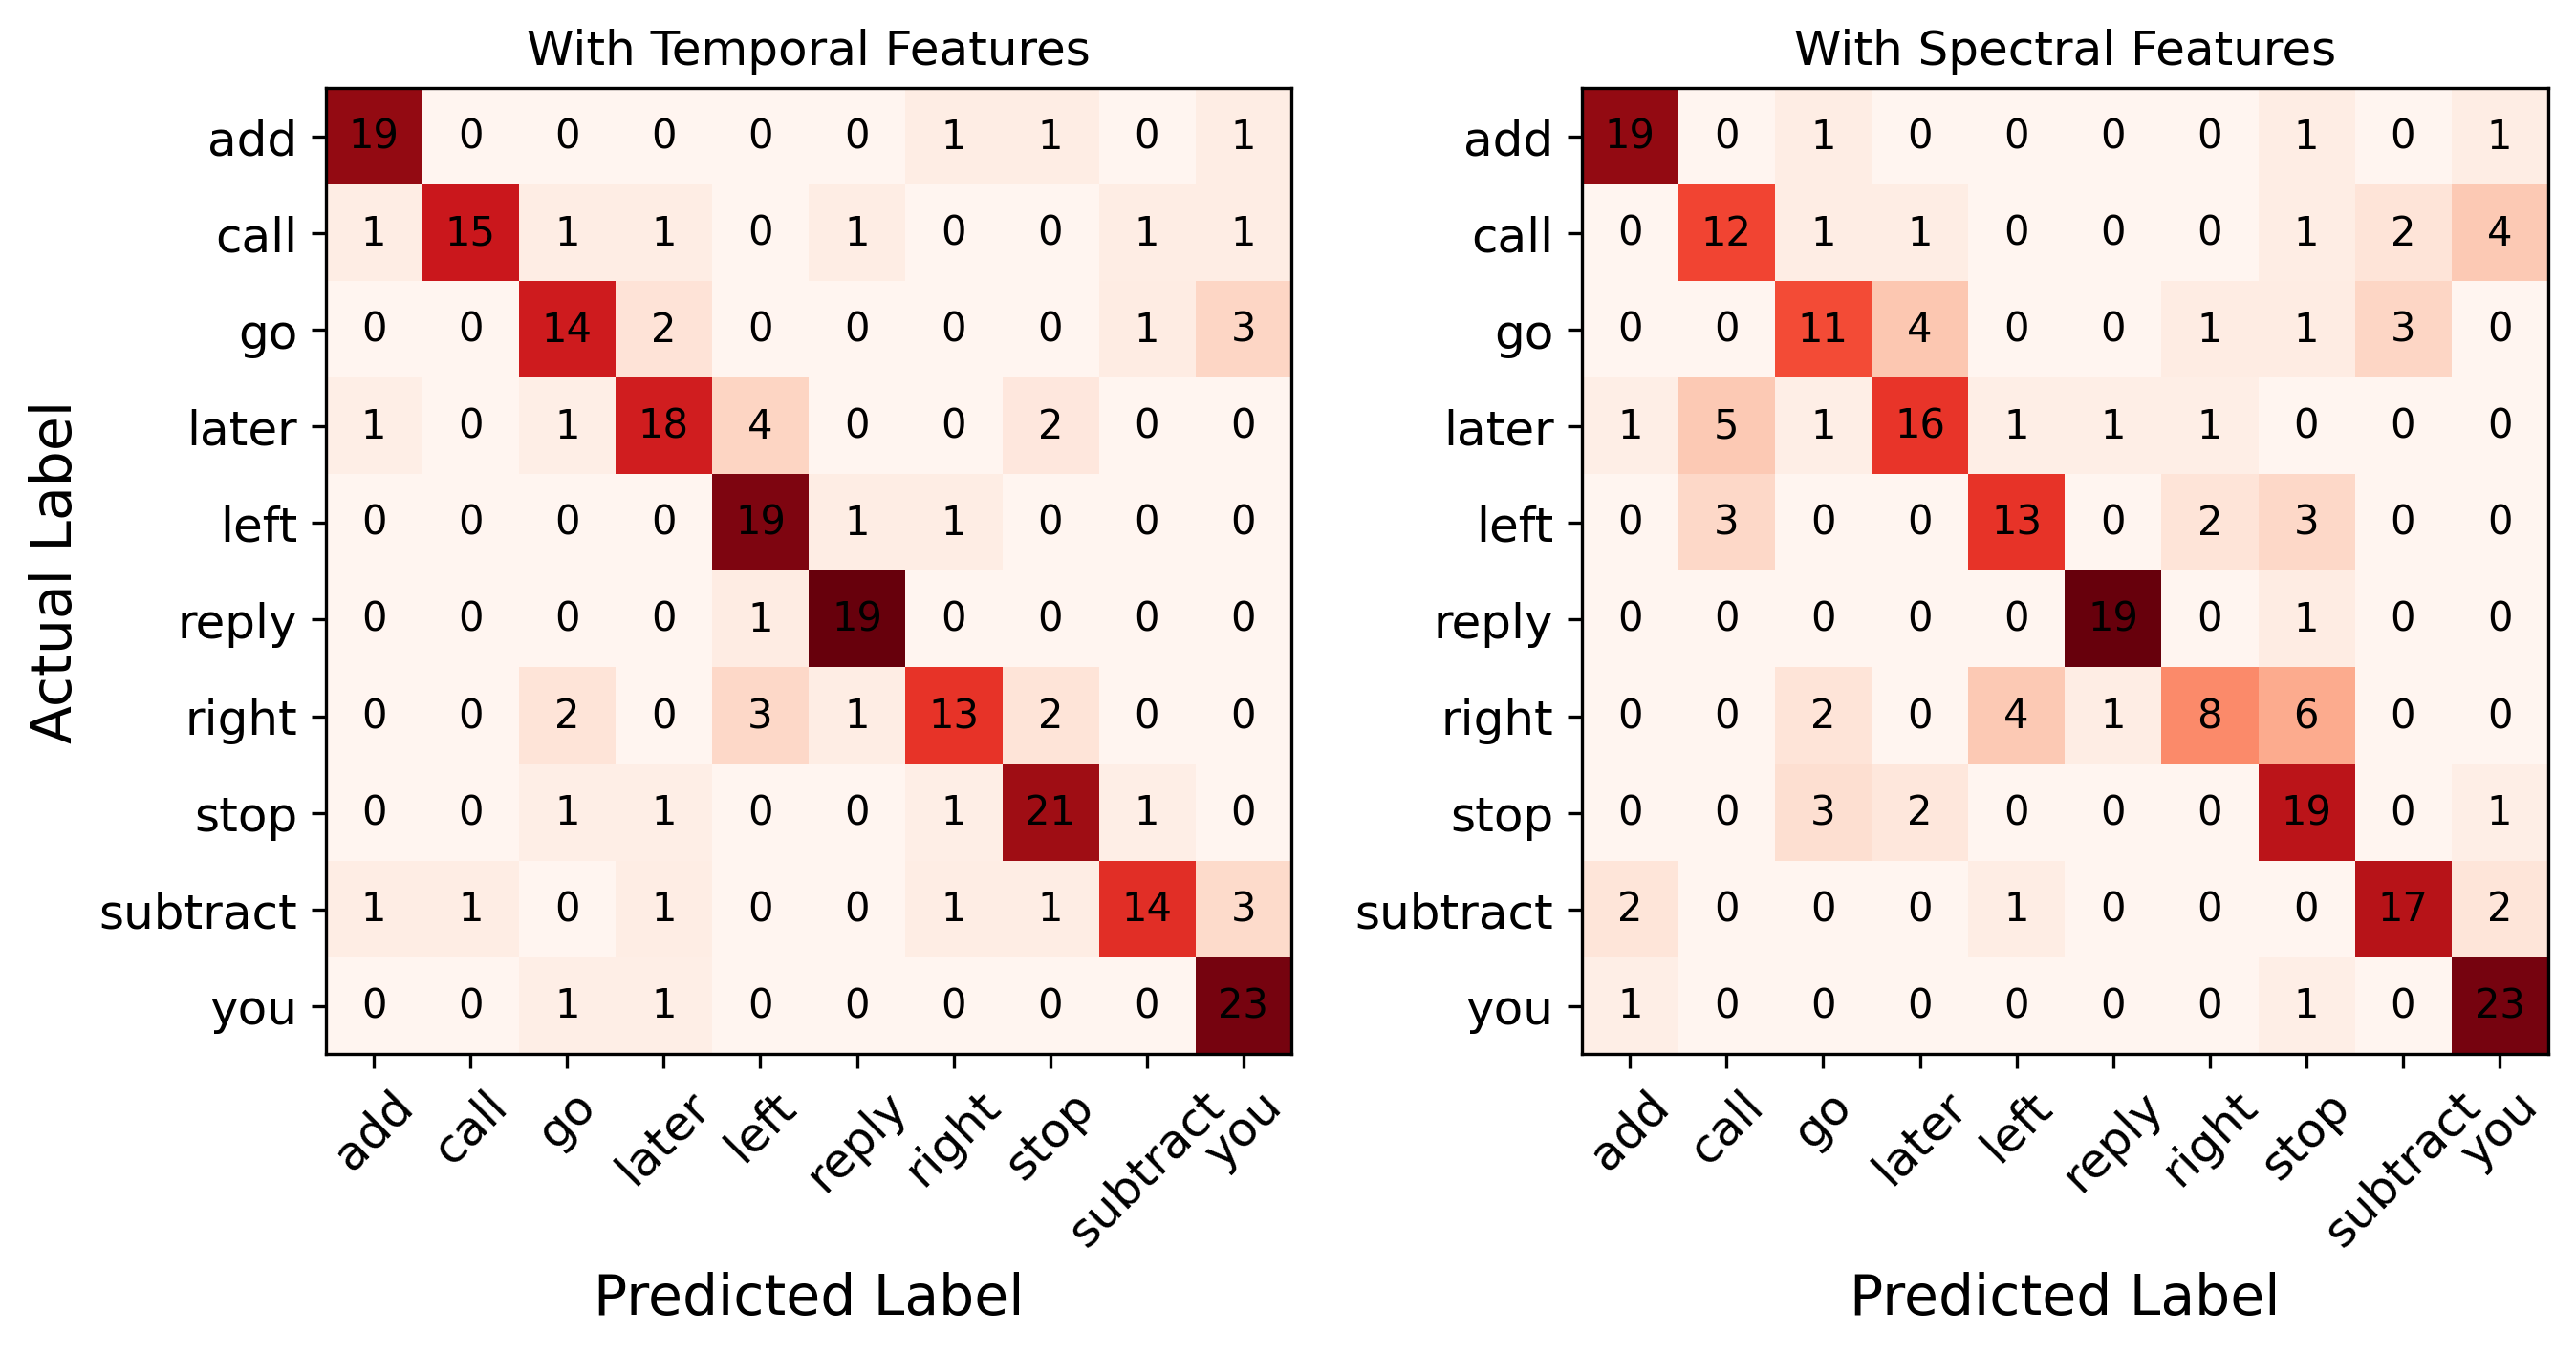

In [51]:
plotCM(a,b.flatten(),c,d.flatten())
# print(b.flatten())

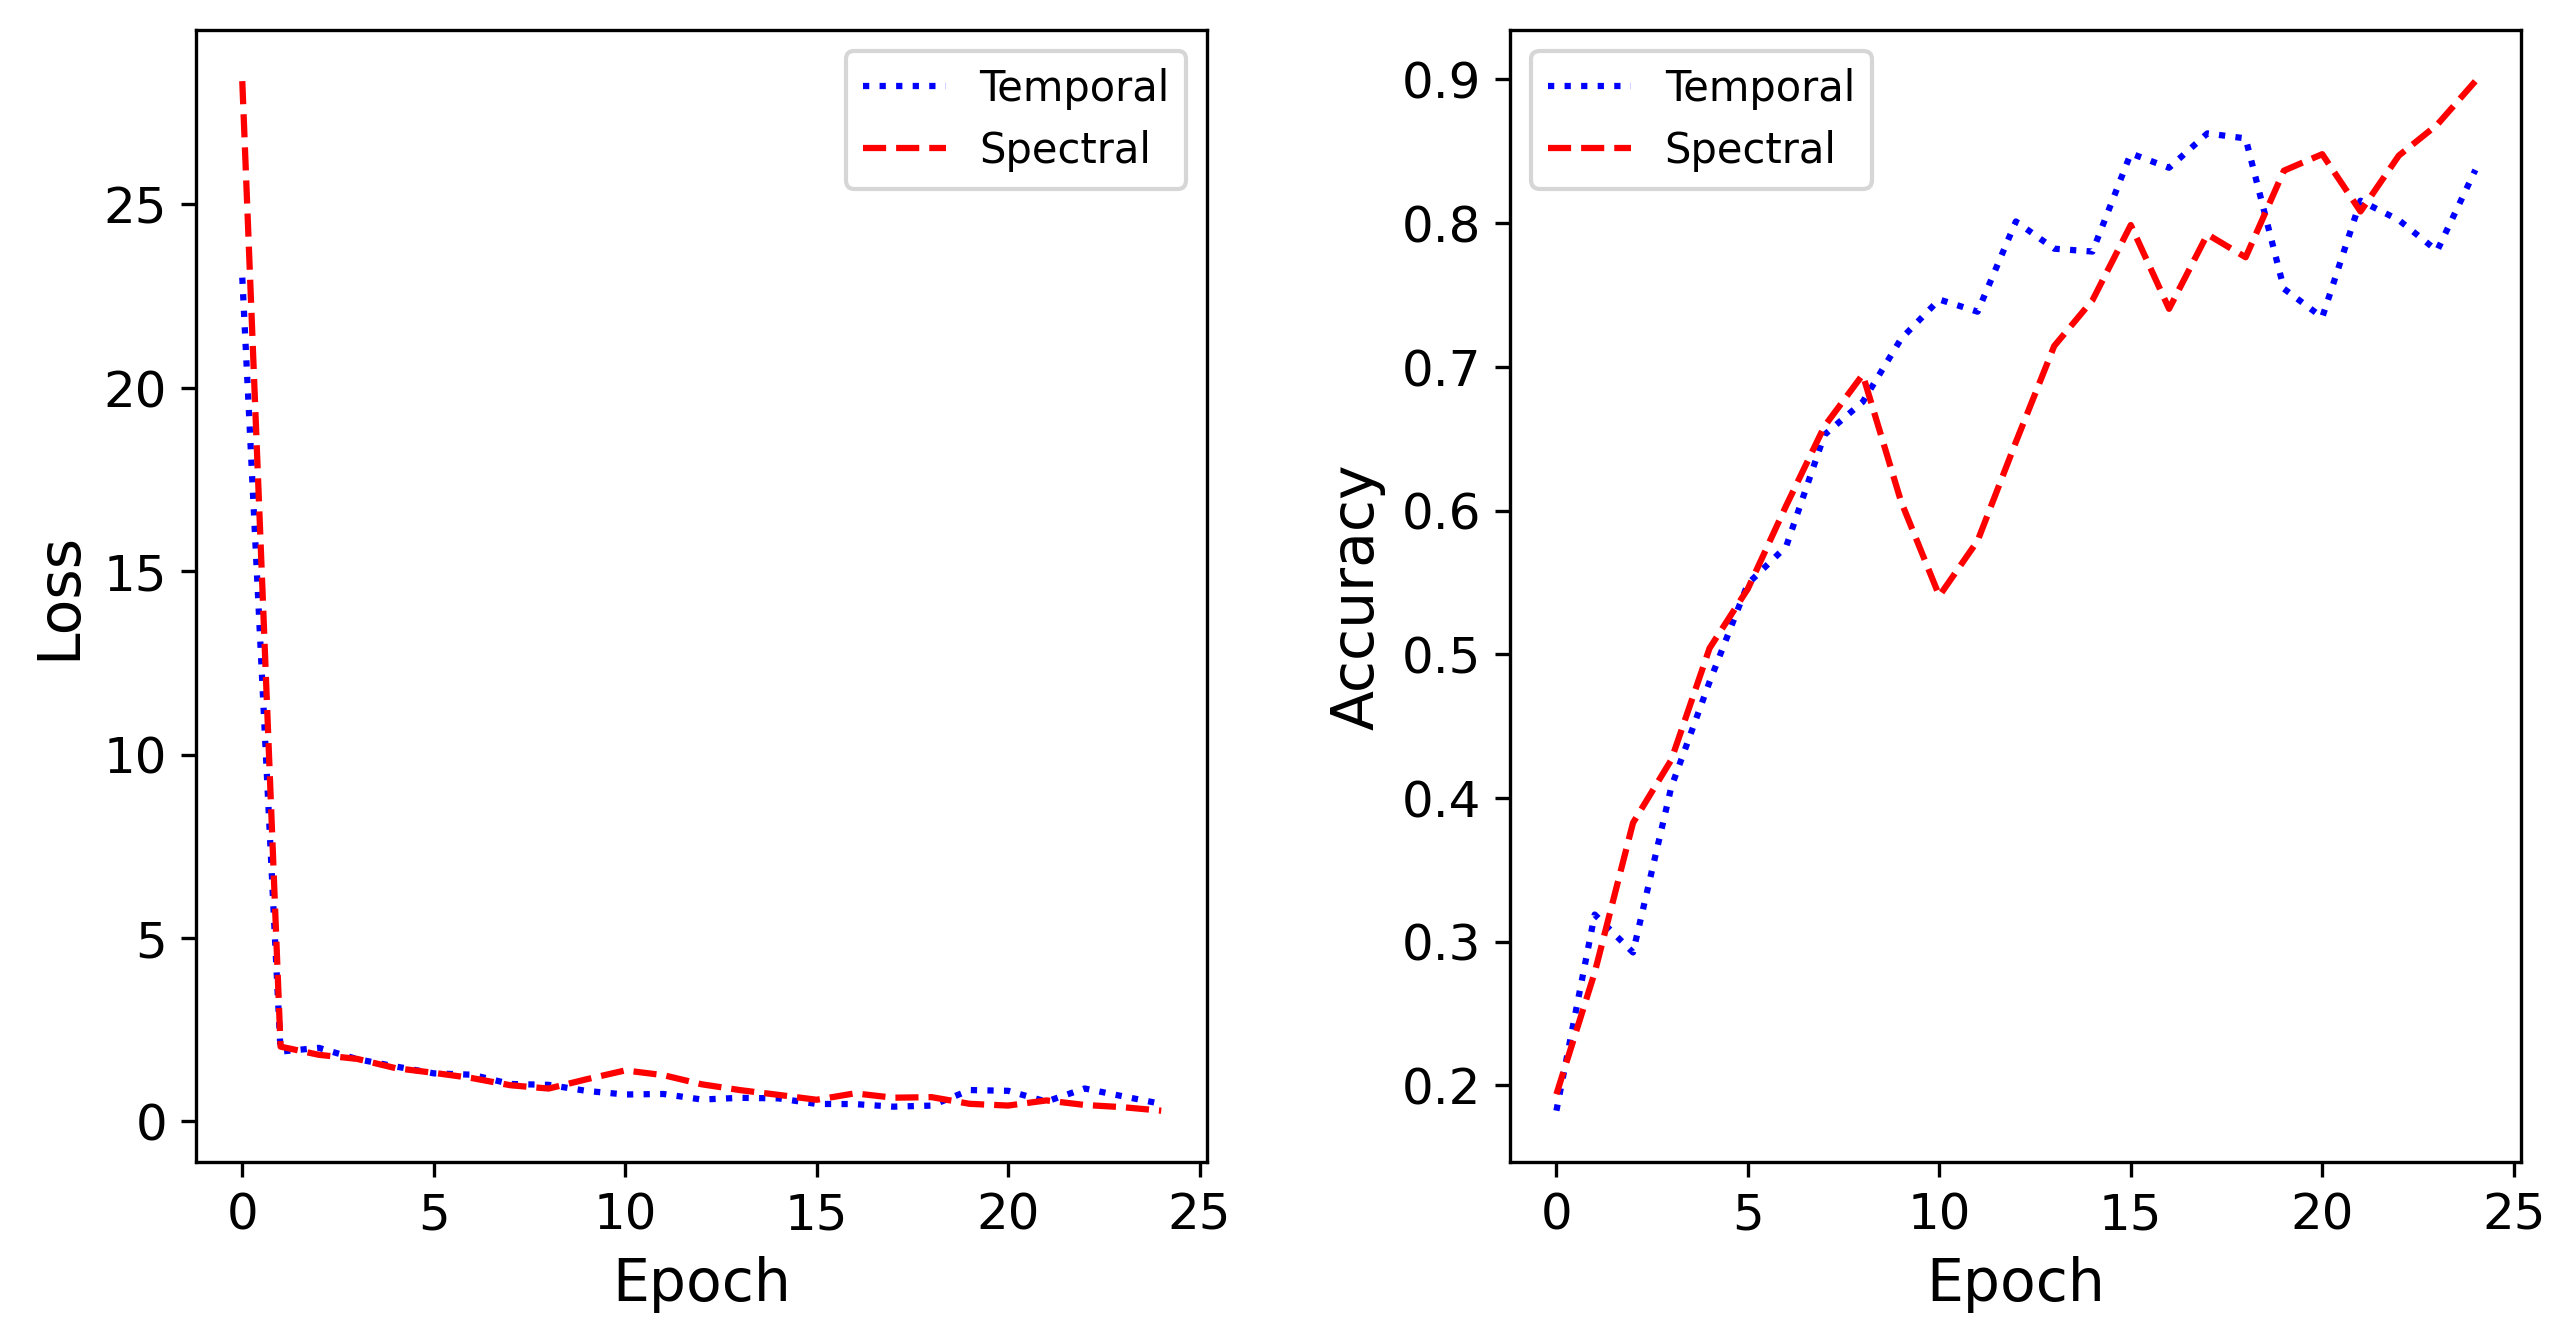

In [52]:

plt.subplot(121)
# plt.title("With Temporal Features")
plt.plot(history_time.history["loss"],"b:")
plt.plot(history_spectral.history["loss"],"r--")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(["Temporal","Spectral"])

plt.subplot(122)
# plt.title("With Temporal Features")
plt.plot(history_time.history["accuracy"],"b:")
plt.plot(history_spectral.history["accuracy"],"r--")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.subplots_adjust(wspace=0.3)
plt.legend(["Temporal","Spectral"])
# save_fig("ALL_MLP_ACCURACY_LOSS")
plt.show()

In [53]:
print("Precision/Recall with Temporal Features")
print(classification_report(e,f))

print("Precision/Recall with Spectral Features")
print(classification_report(g,h))

Precision/Recall with Temporal Features
              precision    recall  f1-score   support

           0       0.78      0.64      0.70        22
           1       0.67      0.57      0.62        21
           2       0.50      0.25      0.33        20
           3       0.46      0.46      0.46        26
           4       0.50      0.71      0.59        21
           5       0.89      0.80      0.84        20
           6       0.53      0.38      0.44        21
           7       0.71      0.60      0.65        25
           8       0.56      0.64      0.60        22
           9       0.52      0.88      0.66        25

    accuracy                           0.60       223
   macro avg       0.61      0.59      0.59       223
weighted avg       0.61      0.60      0.59       223

Precision/Recall with Spectral Features
              precision    recall  f1-score   support

           0       0.79      0.50      0.61        22
           1       0.42      0.52      0.47        2

In [ ]:
# type(X_time)

# #reshaping for 2d cnn
# XX_time = np.zeros((X_time.shape[0], X_time.shape[1], int(X_time.shape[-1]/8), 8))
# YY_time = Y_time



# for i in range(len(XX_time)):
#     for chan in range(XX_time.shape[-1]):
#         for feat in range(XX_time.shape[-2]):
#             XX_time[i, :, feat, chan] = X_time[i, :, XX_time.shape[-2]*chan + feat ]

In [ ]:
# def CNN_Classifier_2D(X_train,Y_train,X_test,Y_test,PLOTS=False):
#     Y_train = tf.keras.utils.to_categorical(Y_train, num_classes = 10)
#     Y_test = tf.keras.utils.to_categorical(Y_test, num_classes = 10)
    
# #     n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], Y_train.shape[1]
#     CNN_model = keras.Sequential()
# #     CNN_model.add(keras.layers.Conv2D(100, kernel_size = 12, input_shape =(n_timesteps,n_features), activation = "relu"))
#     CNN_model.add(keras.layers.Conv2D(100, kernel_size = (5,5), input_shape = X_train.shape[1:], activation = "relu"))
#     CNN_model.add(keras.layers.MaxPool2D(pool_size=(1, 1)))
#     CNN_model.add(keras.layers.Conv2D(100,kernel_size= (6,1),activation="relu"))
#     CNN_model.add(keras.layers.MaxPool2D(pool_size= (1, 1) ))
#     CNN_model.add(keras.layers.Flatten())
#     CNN_model.add(keras.layers.Dense(100,activation="relu"))
#     CNN_model.add(keras.layers.Dense(10,activation="softmax"))

#     opt = keras.optimizers.Adam()

#     CNN_model.compile(optimizer = opt, loss = keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
#     print(CNN_model.summary())
#     history = CNN_model.fit(X_train, Y_train, epochs = 30, batch_size = 50, validation_data =(X_test, Y_test) ,verbose = 1)
#     CNN_prediction = np.array(list(map(np.argmax,CNN_model.predict(X_test))))
    
# #     if(PLOTS=True):
# #         plt.plot(history.history["accuracy"],"r:")
# #         plt.plot(history.history["loss"],"b--")
# #         plt.xlabel("Epoch")
# #         plt.ylabel("Accuracy/ Loss")
# #         plt.legend(["Accuracy","Loss"])
# #         # save_fig("ACC_LOSS_US_FIltered")
    
    
#     return Y_test,CNN_prediction,history

In [54]:
# X_train_time,Y_train_time,X_test_time,Y_test_time = train_test_split(XX_time,Y_en)
# a,b,history_time = CNN_Classifier_2D(X_train_time,Y_train_time,X_test_time,Y_test_time)